In [256]:
print("hello world")

hello world


In [257]:
from langgraph.graph import StateGraph, START, END
import os

In [258]:
from langchain_openai import OpenAI, ChatOpenAI

In [259]:
from dotenv import load_dotenv
load_dotenv()

True

In [260]:
openai_api_key = os.getenv("OPENAI_API_KEY")

In [261]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=openai_api_key
)

In [262]:
#llm.invoke("Hello how are you?")

In [284]:
from typing_extensions import TypedDict
from typing import Annotated, Dict, Any
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage
import requests

In [285]:
# Minimal State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    data: Dict[str, Any]

In [286]:
FLOWS = {
    "insertion_in_db": "https://prod-02.centralindia.logic.azure.com:443/workflows/176b9969d13147aa90ae97d9b53c7ca9/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=cRltkx9lLIr5KRfxpNBvPZcmp2ybs3uxpSM_EvYk42s",
    "doc_download":"https://prod-16.centralindia.logic.azure.com:443/workflows/e8c18012e313410dae07e6ed20ccc816/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=oMl04_zC72XGN8W-ChrED9jW4pvSs5xUEQQA0BuHs3E"
}

In [287]:
def call_flow(flow_name: str, data: dict) -> dict:
    """Call Power Automate flow"""
    try:
        response = requests.post(FLOWS[flow_name])
        return {"success": True}
    except Exception as e:
        return {"success": False, "error": str(e)}
    
def insertion_in_db(state: State):
    result = call_flow("insertion_in_db", state["data"])
    return {
        "messages": [AIMessage(content=f"DB insertion: {'✅' if result['success'] else '❌'}")],
        "data": {**state["data"], "db_result": result}
    }

def doc_download(state: State):
    result = call_flow("doc_download", state["data"])
    return {
        "messages": [AIMessage(content=f"Document download: {'✅' if result['success'] else '❌'}")],
        "data": {**state["data"], "doc_result": result}
    }

In [288]:
def create_pipeline():
    graph = StateGraph(State)
    graph.add_node("insertion_in_db", insertion_in_db)
    graph.add_node("doc_download", doc_download)
    graph.set_entry_point("insertion_in_db")
    graph.add_edge("insertion_in_db", "doc_download")
    graph.add_edge("doc_download", END)
    
    return graph.compile()

In [289]:
def run():
    pipeline = create_pipeline()
    result = pipeline.invoke({"messages": [], "data": {"pipeline_id": "test_001"}})
    
    print("Pipeline completed!")
    for msg in result["messages"]:
        print(f"  {msg.content}")
    
    return result

In [290]:
def visualize():
    pipeline = create_pipeline()
    try:
        from IPython.display import Image, display
        display(Image(pipeline.get_graph().draw_mermaid_png()))
    except Exception:
        print(pipeline.get_graph().draw_mermaid())


Pipeline completed!
  DB insertion: ✅
  Document download: ✅


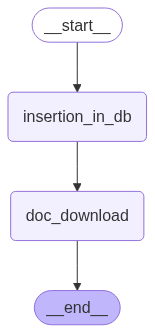

In [292]:
run()
visualize()


In [304]:
import pyodbc
DATABASE = "Agentic_Automation"
conn_str = (
    "DRIVER={SQL Server};"
    "SERVER=216.48.191.98;"
    f"DATABASE={DATABASE};"
    "UID=ibsadmin;"
    "PWD=Viking@@ibs2023;"
)
cnxn = pyodbc.connect(conn_str, autocommit=True)
cursor = cnxn.cursor()

In [325]:
from typing_extensions import TypedDict
from typing import Annotated, Dict, Any
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage
import requests
import time
import pyodbc
from contextlib import closing

# 1) Define the shape of the pipeline state
class State(TypedDict):
    messages: Annotated[list, add_messages]
    data: Dict[str, Any]

# 2) Your two Power Automate endpoints
FLOWS = {
    "insertion_in_db": "https://prod-02.centralindia.logic.azure.com:443/workflows/176b9969d13147aa90ae97d9b53c7ca9/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=cRltkx9lLIr5KRfxpNBvPZcmp2ybs3uxpSM_EvYk42s",
    "doc_download": "https://prod-16.centralindia.logic.azure.com:443/workflows/e8c18012e313410dae07e6ed20ccc816/triggers/manual/paths/invoke?api-version=2016-06-01&sp=%2Ftriggers%2Fmanual%2Frun&sv=1.0&sig=oMl04_zC72XGN8W-ChrED9jW4pvSs5xUEQQA0BuHs3E"
}

def call_flow(flow_name: str, data: dict) -> dict:
    """Trigger a Power Automate flow and report success/failure."""
    try:
        resp = requests.post(FLOWS[flow_name], json=data)
        resp.raise_for_status()
        return {"success": True}
    except Exception as e:
        return {"success": False, "error": str(e)}

def insertion_in_db(state: State) -> State:
    result = call_flow("insertion_in_db", state["data"])
    print(f"DB insertion result: {result}")
    return {
        "messages": [
            AIMessage(f"DB insertion: {'✅' if result['success'] else '❌'}")
        ],
        "data": state["data"]
    }

def wait_for_status_dbinsertion(state: State) -> State:
    """Poll the workflow_status table until status == 'Completed'."""
    conn_str = (
        "DRIVER={SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=Agentic_Automation;"
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )
    query = """
        SELECT DbInsertion
        FROM [Agentic_Automation].[dbo].[workflow_status]
        WHERE WebtopId = ?
    """
    webtop_id = state["data"]["WebtopId"]

    with pyodbc.connect(conn_str, autocommit=True) as conn:
        with closing(conn.cursor()) as cur:
            while True:
                cur.execute(query, webtop_id)
                row = cur.fetchone()
                if row and row[0] == "Completed":
                    break
                time.sleep(5)
    print("DB status: Completed")
    return {
        "messages": [AIMessage("DB status: ✅ Completed")],
        "data": state["data"]
    }

def wait_for_status_docdownload(state: State) -> State:
    """Poll the workflow_status table until status == 'Completed'."""
    conn_str = (
        "DRIVER={SQL Server};"
        "SERVER=216.48.191.98;"
        "DATABASE=Agentic_Automation;"
        "UID=ibsadmin;"
        "PWD=Viking@@ibs2023;"
    )
    query = """
        SELECT DocDownload
        FROM [Agentic_Automation].[dbo].[workflow_status]
        WHERE WebtopId = ?
    """
    webtop_id = state["data"]["WebtopId"]

    with pyodbc.connect(conn_str, autocommit=True) as conn:
        with closing(conn.cursor()) as cur:
            while True:
                cur.execute(query, webtop_id)
                row = cur.fetchone()
                if row and row[0] == "Completed":
                    break
                time.sleep(5)
    print("Doc download status: Completed")

    return {
        "messages": [AIMessage("DB status: ✅ Completed")],
        "data": state["data"]
    }



def doc_download(state: State) -> State:
    result = call_flow("doc_download", state["data"])
    print(f"Document download result: {result}")
    return {
        "messages": [
            AIMessage(f"Document download: {'✅' if result['success'] else '❌'}")
        ],
        "data": {**state["data"], "doc_result": result}
    }

def create_pipeline():
    graph = StateGraph(State)
    graph.add_node("insertion_in_db", insertion_in_db)
    graph.add_node("wait_for_status_dbinsertion",  wait_for_status_dbinsertion)
    graph.add_node("doc_download",     doc_download)
    graph.add_node("wait_for_status_docdownload", wait_for_status_docdownload)

    graph.set_entry_point("insertion_in_db")
    graph.add_edge("insertion_in_db", "wait_for_status_dbinsertion")
    graph.add_edge("wait_for_status_dbinsertion", "doc_download")
    graph.add_edge("doc_download", "wait_for_status_docdownload")
    graph.add_edge("wait_for_status_docdownload", END)

    return graph.compile()

if __name__ == "__main__":
    pipeline = create_pipeline()
    # seed the pipeline with an ID of your workflow run
    result = pipeline.invoke({
        "messages": [],
        "data": {"WebtopId": "ABC123"}
    })
    print("Pipeline completed, messages:")
    for msg in result["messages"]:
        print(" •", msg.content)


DB insertion result: {'success': True}
DB status: Completed
Document download result: {'success': True}
Doc download status: Completed
Pipeline completed, messages:
 • DB insertion: ✅
 • DB status: ✅ Completed
 • Document download: ✅
 • DB status: ✅ Completed
